In [2]:
include("TN_Superfermionic_Mesoscopic_Leads/Code/Interacting_functions_wGPU.jl")

Precompiling ITensors
  ✓ IteratorInterfaceExtensions
  ✓ LLVMLoopInfo
  ✓ LaTeXStrings
  ✓ ExprTools
  ✓ HalfIntegers
  ✓ CompilerSupportLibraries_jll
  ✓ CEnum
  ✓ ArgCheck
  ✓ AbstractFFTs
  ✓ InverseFunctions
  ✓ SerializedElementArrays
  ✓ InitialValues
  ✓ OrderedCollections
  ✓ Reexport
  ✓ ExternalDocstrings
  ✓ DataValueInterfaces
  ✓ Compat
  ✓ FillArrays
  ✓ RandomNumbers
  ✓ Requires
  ✓ MPIPreferences
  ✓ SentinelArrays
  ✓ DocStringExtensions
  ✓ InlineStrings
  ✓ CompositionsBase
  ✓ BFloat16s
  ✓ InvertedIndices
  ✓ IfElse
  ✓ DefineSingletons
  ✓ BitIntegers
  ✓ CommonWorldInvalidations
  ✓ DataAPI
  ✓ Zeros
  ✓ PackageExtensionCompat
  ✓ VectorInterface
  ✓ UnsafeAtomics
  ✓ ConstructionBase
  ✓ Indexing
  ✓ Scratch
  ✓ TupleTools
  ✓ StaticArraysCore
  ✓ Statistics
  ✓ Hwloc_jll
  ✓ libaec_jll
  ✓ demumble_jll
  ✓ TableTraits
  ✓ MicrosoftMPI_jll
  ✓ MacroTools
  ✓ NVTX_jll
  ✓ Functors
  ✓ OpenSSL_jll
  ✓ JuliaNVTXCallbacks_jll
  ✓ LLVMExtra_jll
  ✓ CUDA_Driver_jll


Energy_Current_HS_time_dependent (generic function with 2 methods)

Let's consider the same Spectral density and logarithmic linear discretization that we have been using the whole time:

In [3]:
using LinearAlgebra
using FlexiMaps

W = 8.0
Γ = W/8
J(ω) = abs(ω) <= abs(W) ? Γ : 0 #Spectral density Γ = W/8 in this case

function Logarithmic_linear_arrays(L, J)
    #L: lead size
    #J: Spectral density    
    
    #We need to define εk for the lead. In particular, we use the logarithmic-linear discretization of the paper. As this is just for the article, it is not worthy to put it with the other functions in NonInteacting_functions.jl
    
    W_log = W #W
    W_lin = W_log/2 #W* = W/2
    
    L_log = L*0.2
    L_lin = L - L_log
    
    Lin_Window = LinRange(-W_lin, W_lin, Int(L_lin))
    Log_Window = maprange(log, W_lin, W_log, length=Int(L_log/2 + 1))
    
    εk = Float64[]
    append!(εk, -reverse( Log_Window[2:length(Log_Window)]), Lin_Window, Log_Window[2:length(Log_Window)])
    
    γk = [εk[k+1] - εk[k] for k=1:Int(L/2)]
    append!(γk, reverse(γk))

    κkp = ComplexF64[sqrt(J(εk[k])*γk[k]/(2.0*pi)) for k=1:L] #Kp = sqrt(J(e)*γ/(2*pi))

    return εk, γk,  κkp
end

Precompiling FlexiMaps
  ✓ DataPipes
  ✓ FlexiMaps
  2 dependencies successfully precompiled in 5 seconds. 21 already precompiled.
Precompiling DictionariesExt
  ✓ FlexiMaps → DictionariesExt
  ✓ FlexiMaps → UnitfulExt
  2 dependencies successfully precompiled in 2 seconds. 25 already precompiled.


Logarithmic_linear_arrays (generic function with 1 method)

In [64]:
#Global variables by default
μ_L, μ_R = W/16, W/16 #As we want to focus in Heat rectification, we should not have gradient of chemical potential.

ts = (W/8)

function fk_arrays(εk_array_L, εk_array_R)
    
    fk_array_L = [fermi_dirac_distribution(ε, μ_L, β_L) for ε = εk_array_L]
    fk_array_R = [fermi_dirac_distribution(ε, μ_R, β_R) for ε = εk_array_R]
    
    return fk_array_L, fk_array_R
end

fk_arrays (generic function with 1 method)

In [83]:
# β_L, β_R = 1/(10*ts), 1/(2*ts) #Forward Bias: TL > TR
β_L, β_R = 1/(2*ts), 1/(10*ts) #Reverse Bias: TL < TR

(0.5, 0.1)

Possible sizes: L = 10, 20. D = 2, 4

In [84]:
#Lead Parameters
L, R = 10, 10
εk, γk, κp = Logarithmic_linear_arrays(L, J)
fk_L, fk_R = fk_arrays(εk, εk);

In [85]:
#System Parameters
D = 2
U = 1.2*ts
E = 4
μ = -E*(D+1)/4

ε_system = [(μ+0.5E*j) for j =1:D]; #Tilted system energies

In [86]:
GPU = false #Thermal state is faster without GPU

false

In [87]:
M = L + D + R

sites = siteinds("S=1/2",2*M)
I_vec = Build_left_vacuum(sites);

In [88]:
#Let's use the thermal state as the start point for the time evolution:

Swap_Gates, TEBD_Gates = Build_Gates(sites, εk, γk, 0*κp, fk_L, εk, γk, 0*κp, fk_R, ε_system, ts, U); #0*Kp_array = no coupling between the lead and the system

NumSteps = 1000
@time Thermal_State, Occupation_Matrix_t = Apply_TEBD(I_vec, I_vec, Swap_Gates, TEBD_Gates, NumSteps); #maxdim = 40 by default
@show JP = Particle_Current(Thermal_State, I_vec, γk, fk_L, Float64[], Float64[])
@show JE = Energy_Current(Thermal_State, I_vec, γk, fk_L, εk, κp, Float64[], Float64[], Float64[], ComplexF64[]);

10.0 % Completed.
20.0 % Completed.
30.0 % Completed.
40.0 % Completed.
50.0 % Completed.
60.0 % Completed.
70.0 % Completed.
80.0 % Completed.
90.0 % Completed.
100.0 % Completed.
 91.592237 seconds (340.25 M allocations: 92.832 GiB, 7.08% gc time, 0.00% compilation time)
JP = Particle_Current(Thermal_State, I_vec, γk, fk_L, Float64[], Float64[]) = -1.2291754915492721e-16
JE = Energy_Current(Thermal_State, I_vec, γk, fk_L, εk, κp, Float64[], Float64[], Float64[], ComplexF64[]) = 8.11595688613737e-15


In [89]:
#ModificateThermal_Statef Apply_TEBD for calculating JE during the TEBD

function Apply_TEBD_MODIFIED(Psi_0::MPS, I_vec::MPS, Swap_Gates::Vector{ITensor}, TEBD_Gates::Vector{ITensor}, NumSteps::Int64, maxdim::Int64 = 40, file_path::String = "") 

    cutoff = 1E-15 #Should I include cutoff as optional parameter?
    
    length(Swap_Gates) == 0 ? L = 0 : L = length(Swap_Gates) + 1

    Occupation_Matrix_t = zeros(100 + 1, Int(length(Psi_0)/2))
    JE_t = []
    times_array = [0.0]
    
    Psi_t = Psi_0
    norm_t = inner(I_vec, Psi_t)
    Psi_t = Psi_t/norm_t
    
    Occupation_Matrix_t[1,:] = Occupations_per_site(Psi_t, I_vec)
    append!(JE_t, Energy_Current(Psi_t, I_vec, γk, fk_L, εk, κp, Float64[], Float64[], Float64[], ComplexF64[])) #USES GLOBAL VARIABLES
    
    
    Reverse_SWAP_Gates = reverse(Swap_Gates)

    for i = 1:NumSteps 
        
        L != 0 ? orthogonalize!(Psi_t,site_SF(L) + 1) : nothing #orthonormalization center between the final site of the lead and the first site of the system
        L != 0 ? Psi_t = apply(Swap_Gates, Psi_t; cutoff=cutoff, maxdim=maxdim) : nothing #moving system and his ancilla to the second physical site i.e. Lead1,lead1',S1,S1',...,leadL, leadL', S2,S2'..., SD,SD',Lead1,Lead1',...,LeadR,LeadR'. maxdim = 1, SWAPS should no shange bond dimension.
        
        orthogonalize!(Psi_t,1) #make all the lattice right normalized
        Psi_t = apply(TEBD_Gates, Psi_t; cutoff=cutoff, maxdim=maxdim)
        
        L != 0 ? Psi_t = apply(Reverse_SWAP_Gates, Psi_t; cutoff=cutoff, maxdim=maxdim) : nothing #Moving system and his ancilla to his usual position i.e. Lead1,lead1', ...,leadL,leadL',S1,S1',...,SD,SD',Lead1,Lead1',...,LeadR,LeadR'. maxdim = 1, SWAPS should no shange bond dimension.
        
        norm_t = inner(I_vec, Psi_t)
        Psi_t = Psi_t/norm_t 

        GPU ? CUDA.reclaim() : nothing #GPU Modification

        if (i*100/NumSteps)%1 == 0.0
            row = Int((i*100/NumSteps)) + 1
            # @time Occupation_Matrix_t[row,:] = Occupations_per_site(Psi_t, I_vec)
            append!(JE_t, Energy_Current(Psi_t, I_vec, γk, fk_L, εk, κp, Float64[], Float64[], Float64[], ComplexF64[])) #USES GLOBAL VARIABLES
            append!(times_array, dt*i) #USES GLOBAL VARIABLES
        end
        
        if (i*100/NumSteps)%10 == 0.0
            println(string((i*100/NumSteps))*" % Completed.")

            if file_path != ""

                GPU ? Psi_cpu = NDTensors.cpu(Psi_t) : Psi_cpu = Psi_t #We need to move the MPS back to the CPU to save it into a .h5 file.
                f = h5open(file_path*"_NESS_MPS.h5","w")
                write(f,"MPS",Psi_cpu)
                close(f)        
                
                writedlm(file_path*"_NESS_Occupations.txt", Occupation_Matrix_t)        
            end
        end
    end
    return Psi_t, Occupation_Matrix_t, JE_t, times_array

end


Apply_TEBD_MODIFIED (generic function with 3 methods)

In [90]:
GPU = true

Thermal_State = gpu(Thermal_State)
I_vec = gpu(I_vec)

Swap_Gates, TEBD_Gates = Build_Gates(sites, εk, γk, κp, fk_L, εk, γk, κp, fk_R, ε_system, ts, U, dt);

In [91]:
#TN Parameters
maxdim = 80;
dt = 0.05

0.05

In [92]:
NumSteps = 100
@time NESS, Occupation_Matrix_t, JE_t, times_array = Apply_TEBD_MODIFIED(Thermal_State, I_vec, Swap_Gates, TEBD_Gates, NumSteps, maxdim); #maxdim = 40 by default

10.0 % Completed.
20.0 % Completed.
30.0 % Completed.
40.0 % Completed.
50.0 % Completed.
60.0 % Completed.
70.0 % Completed.
80.0 % Completed.
90.0 % Completed.
100.0 % Completed.
433.085070 seconds (141.51 M allocations: 21.374 GiB, 0.84% gc time)


In [93]:
using Plots

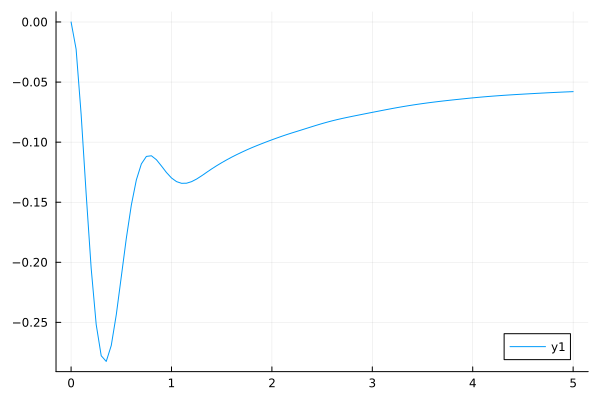

In [95]:
plot(times_array, JE_t)

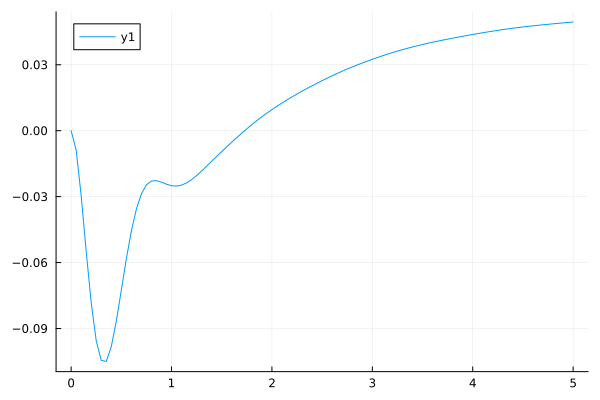

In [82]:
plot(times_array, JE_t)

In [80]:
#approximately 4.7 seconds per step in the TEBD. => 

In [81]:
CUDA.memory_status()#We are not using almost memory, maybe I can run this locally. Let's play a little bit more

Effective GPU memory usage: 12.64% (4.012 GiB/31.739 GiB)
Memory pool usage: 540.228 MiB (3.625 GiB reserved)


**runtime test:**

In [57]:
initial_state = gpu(randomMPS(sites, maxdim));

In [59]:
NumSteps = 10
@time NESS, Occupation_Matrix_t = Apply_TEBD(initial_state, I_vec, Swap_Gates, TEBD_Gates, NumSteps, maxdim); #maxdim = 40 by default

10.0 % Completed.
20.0 % Completed.
30.0 % Completed.
40.0 % Completed.
50.0 % Completed.
60.0 % Completed.
70.0 % Completed.
80.0 % Completed.
90.0 % Completed.
100.0 % Completed.
 46.314371 seconds (14.11 M allocations: 2.025 GiB, 0.83% gc time)


In [63]:
NumSteps = 10
@time NESS, Occupation_Matrix_t, JE_t, times_array = Apply_TEBD_MODIFIED(initial_state, I_vec, Swap_Gates, TEBD_Gates, NumSteps, maxdim); #maxdim = 40 by default

10.0 % Completed.
20.0 % Completed.
30.0 % Completed.
40.0 % Completed.
50.0 % Completed.
60.0 % Completed.
70.0 % Completed.
80.0 % Completed.
90.0 % Completed.
100.0 % Completed.
 47.454436 seconds (16.31 M allocations: 2.449 GiB, 0.94% gc time)
